### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [3]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [4]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

Failed on attempt 1 to download http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.gwf
Failed on attempt 2 to download http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.gwf
Failed on attempt 3 to download http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.gwf
Failed on attempt 4 to download http://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.gwf


**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them.

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

**Context Task 1**


---
A timeseries gathers data in equivalent time samples, over a duration $T$. Given a number of data points $N$ and some sampling rate $f_{s}$, $T$ is determined by $ T = \frac{N}{f_{s}} $.

The time resolution (spacing between data points) is given by $\Delta_{t} = \frac{1}{f_{s}}$, and the frequency resolution by $\Delta_{f} = \frac{1}{T}$. Essentially, the longer the datarun, the better different frequencies can be differentiated from one another.

Finally, combining those equations: $N = \frac{1}{\Delta_{t}\Delta_{f}}$

---

In [16]:
## Time Duration
print(f"Duration of TimeSeries = {data.duration}")

## Sampling rate
print(f"Sampling Rate = {data.sample_rate}")

## Data Points
print(f"Number of data points N = {data.duration*data.sample_rate}")

## Resolutions
print(f"\u0394t = {data.delta_t}")
print(f"\u0394f = {data.delta_f}")

## Relation
N = 1/(data.delta_t*data.delta_f)
print(f"To verify the relation between resolutions and data points: N = 1/\u0394t\u0394f = {N}")


Duration of TimeSeries = 32.0
Sampling Rate = 4096.0
Number of data points N = 131072.0
Δt = 0.000244140625
Δf = 0.03125
To verify the relation between resolutions and data points: N = 1/ΔtΔf = 131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

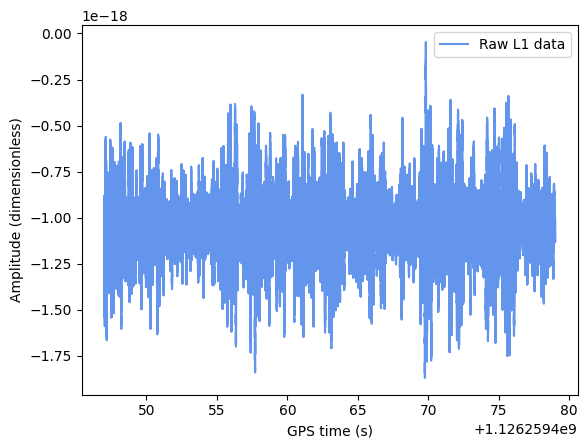

In [17]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton.

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design.

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency.

_Hint_: Note that the PSD is a frequency series.

**Context Task 2**


---
Calculates a PSD (Power Spectral Density), based on the duration $T$ and the corresponding frequency resolution $\Delta_f$.

According to Nyquist-Shannon theorem, the sampling rate required to capture a signal with maximum frequency $f_{max}$ has to obey the follwing relation:
$f_s \ge 2f_{max}$. In other words, with a given rate, the maximum frequency that can be captured is half of it.

---

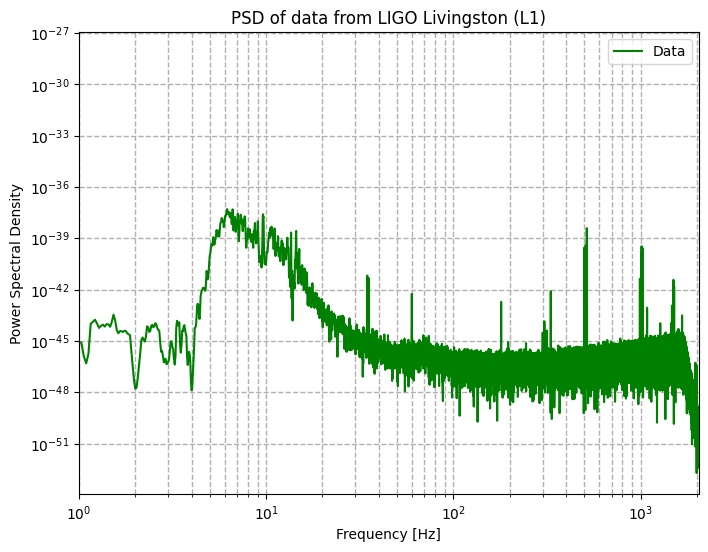

In [39]:
## Calculate the PSD
psd = data.filter_psd(data.duration, data.delta_f, flow=1) #estimates the Power Spectral Density (PSD) of the input strain data

## Plot the data
plt.figure(figsize=(8, 6))
plt.plot(psd.sample_frequencies, psd, label ="Data", color = "green")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.title("PSD of data from LIGO Livingston (L1)")

plt.xlim(1, psd.sample_rate/2)
plt.yscale("log")
plt.xscale("log")
plt.grid(True, which="both", ls="--", linewidth=1)

plt.legend()

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`.

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


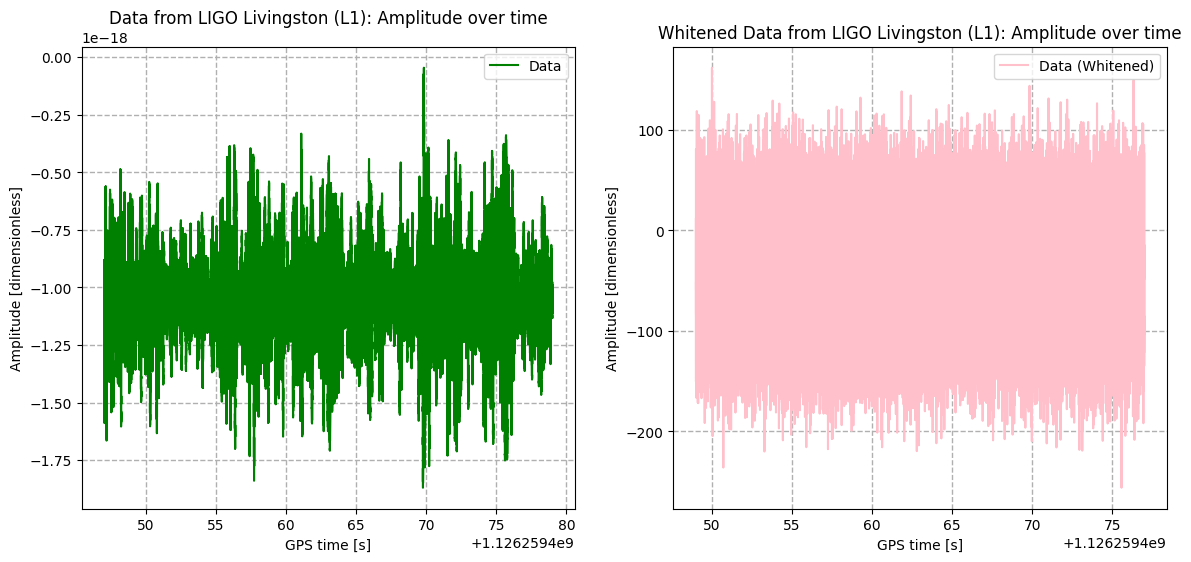

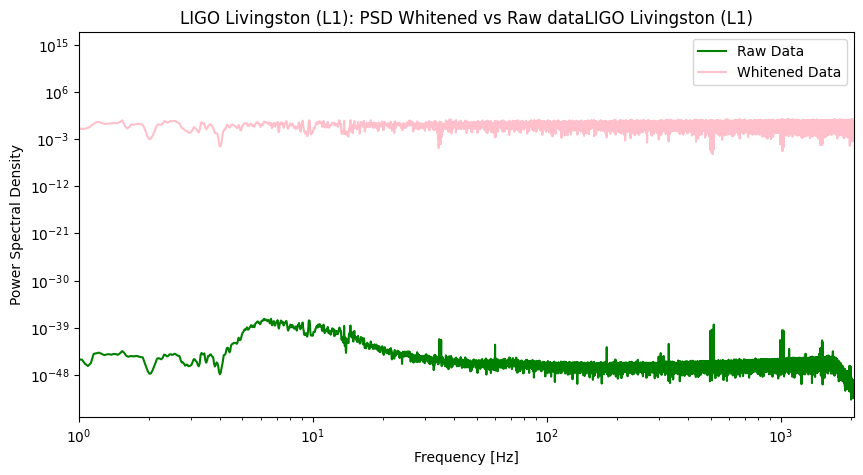

In [37]:
## Whitens the data with a segment duration and max_filter_duration of 4
whitened_data = data.whiten(segment_duration = 4, max_filter_duration = 4)

## Same as before, calculates the PSD for the new filtered data.
whitened_psd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow=1)

## On the same plot, compare the data (magnitudes) before and after whitening
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(data.sample_times, data, label="Data", color="green")

plt.xlabel("GPS time [s]")
plt.ylabel("Amplitude [dimensionless]")
plt.title("Data from LIGO Livingston (L1): Amplitude over time")

plt.grid(True, which="both", ls="--", linewidth=1)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(whitened_data.sample_times, whitened_data, label="Data (Whitened)", color="pink")

plt.xlabel("GPS time [s]")
plt.ylabel("Amplitude [dimensionless]")
plt.title("Whitened Data from LIGO Livingston (L1): Amplitude over time")

plt.grid(True, which="both", ls="--", linewidth=1)
plt.legend()

## On the same graph, plots PSDs from both raw and cropped (whitened) data
plt.figure(figsize=(10, 5))
plt.loglog(psd.sample_frequencies, psd, label="Raw Data", color="green")
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label="Whitened Data", color="pink")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.title("LIGO Livingston (L1): PSD Whitened vs Raw dataLIGO Livingston (L1)")

plt.xlim(1, whitened_data.sample_rate/2)
plt.legend()


Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data.


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

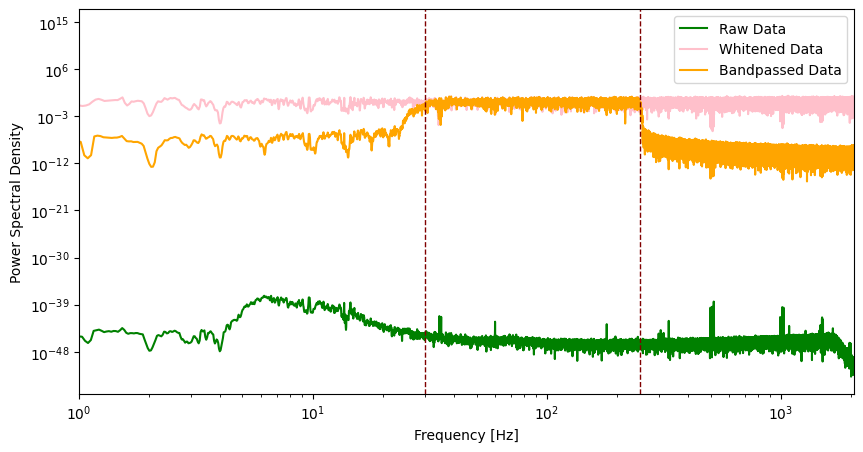

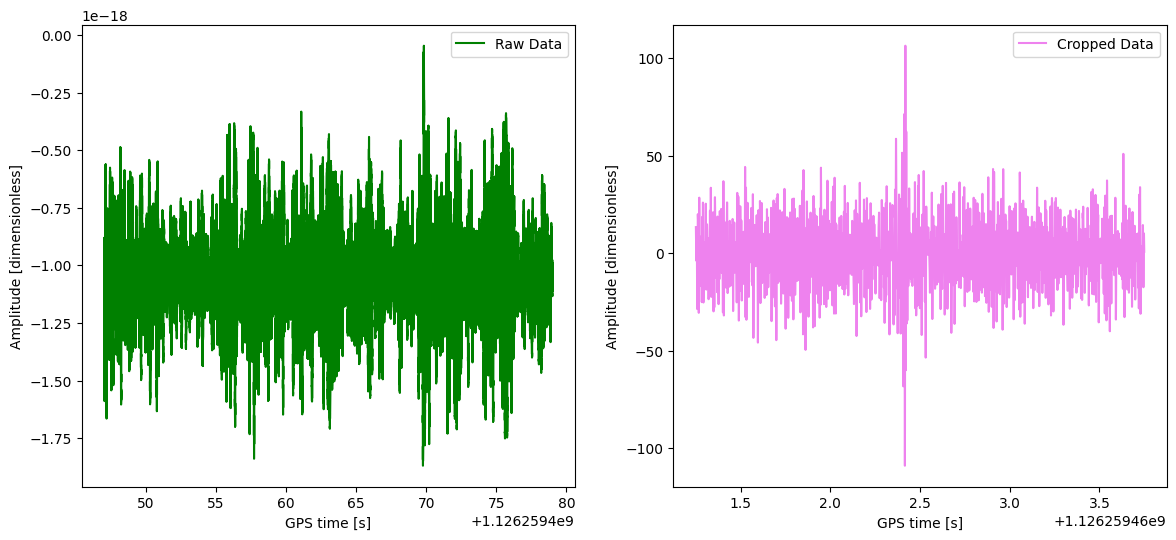

In [47]:
## Prepares the bandpass filter for the data.
lowpass = whitened_data.lowpass_fir(250, 512)
bandpass = lowpass.highpass_fir(30,512)

## Calculates new PSD
bandpass_white_psd = bandpass_white.filter_psd(bandpass_white.duration, bandpass_white.delta_f, flow=1)

## On the same graph, plots PSDs from raw, whitened and bandpassed data
plt.figure(figsize=(10, 5))
plt.loglog(psd.sample_frequencies, psd, label="Raw Data", color="green")
plt.loglog(whitened_psd.sample_frequencies, whitened_psd, label="Whitened Data", color="pink")
plt.loglog(bandpass_white_psd.sample_frequencies, bandpass_white_psd, label="Bandpassed Data", color="orange")

# Plot vertical lines at the bandpass edges
plt.axvline(x=250, color='maroon', linestyle='--', linewidth=1)
plt.axvline(x=30, color='maroon', linestyle='--', linewidth=1)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")

plt.xlim(1, whitened_data.sample_rate/2)
plt.legend()

## Crop the bandpass 12s left and 13s right
cropped_bandpass_white = bandpass_white.crop(12, 13)


## Plotted next to each other, the amplitudes of the raw data vs the whitened-bandpassed-cropped one
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(data.sample_times, data, label="Raw Data", color="green")

plt.xlabel("GPS time [s]")
plt.ylabel("Amplitude [dimensionless]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(cropped_bandpass_white.sample_times, cropped_bandpass_white, label="Cropped Data", color="violet")

plt.xlabel("GPS time [s]")
plt.ylabel("Amplitude [dimensionless]")
plt.legend()


**Explanation Task 4**


---
We define a low-pass and apply a high-pass filter to create a bandpass filter, sorting out signals which do not fit the desired frequencies. This bandpass allows the already whitened data to appear especially amplified in the frequency range that we want to measure. The other signal seems to be suppressed, but still smoothed compared to the raw data.

---

**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

Text(0, 0.5, 'Frequency (Hz)')

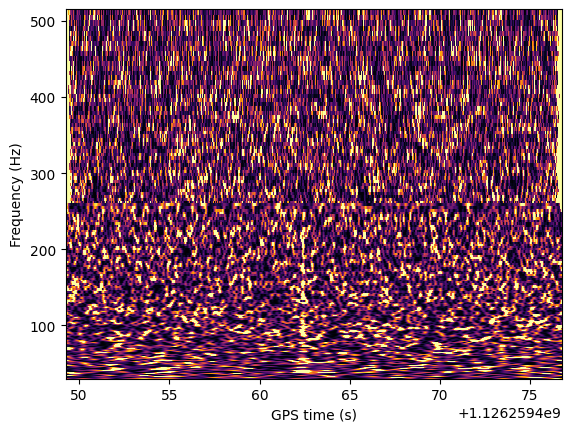

In [50]:
## Creating the spectogram in the frequency range, with a good quality factor. Set range to [30,512] since that is the bandpass range.
time, freqs, qplane = bandpass_white.qtransform(delta_t= bandpass_white.delta_t, logfsteps=200, frange=(30,512), qrange=(110,110))

## Plotting time vs freqency vs 2D qtransform, with qtransform expressed over colour.
plt.pcolormesh(time, freqs, qplane, vmax = 4, cmap= "inferno")
plt.xlabel("GPS time [s]")
plt.ylabel("Frequency [Hz]")


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Good job! This is the end of the second part. Maybe you can go for a break?